In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

In [2]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_train = datasets.ImageFolder(root='dataset', transform=train_transforms)
dataset_val = datasets.ImageFolder(root='dataset', transform=val_transforms)

targets = np.array([s[1] for s in dataset_train.samples])

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(targets)),targets))

train_dataset = Subset(dataset_train,train_idx)
val_dataset = Subset(dataset_val,val_idx)

## Setup Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # en mac cambiar 'cuda' por 'mps' esta implementación se uso en una rtx 3060 

In [4]:
print(f"Using device: {device}")

Using device: cuda


# Efficient Net V2 Small

## Hiperparametros

In [8]:
BATCH_SIZE = 32
NUM_CLASSES = 9
INTIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-4

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
num_classes = 9
model = efficientnet_v2_s(weights=weights)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)
model = model.to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE_HEAD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [15]:
liveloss = PlotLosses()
best_acc = 0 
logs = {}

In [11]:
for param in model.features.parameters():
    param.requires_grad = False

In [12]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    correct = total = train_loss = 0
    for xb,yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    logs['loss'] = train_loss / len(loader)
    logs['accuracy'] = correct/total

In [13]:
def evaluate(model, loader, criterion):
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            val_loss += loss.item()
            _, preds = outputs.max(1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

    logs['val_loss'] = val_loss / len(loader)
    logs['val_accuracy'] = correct / total


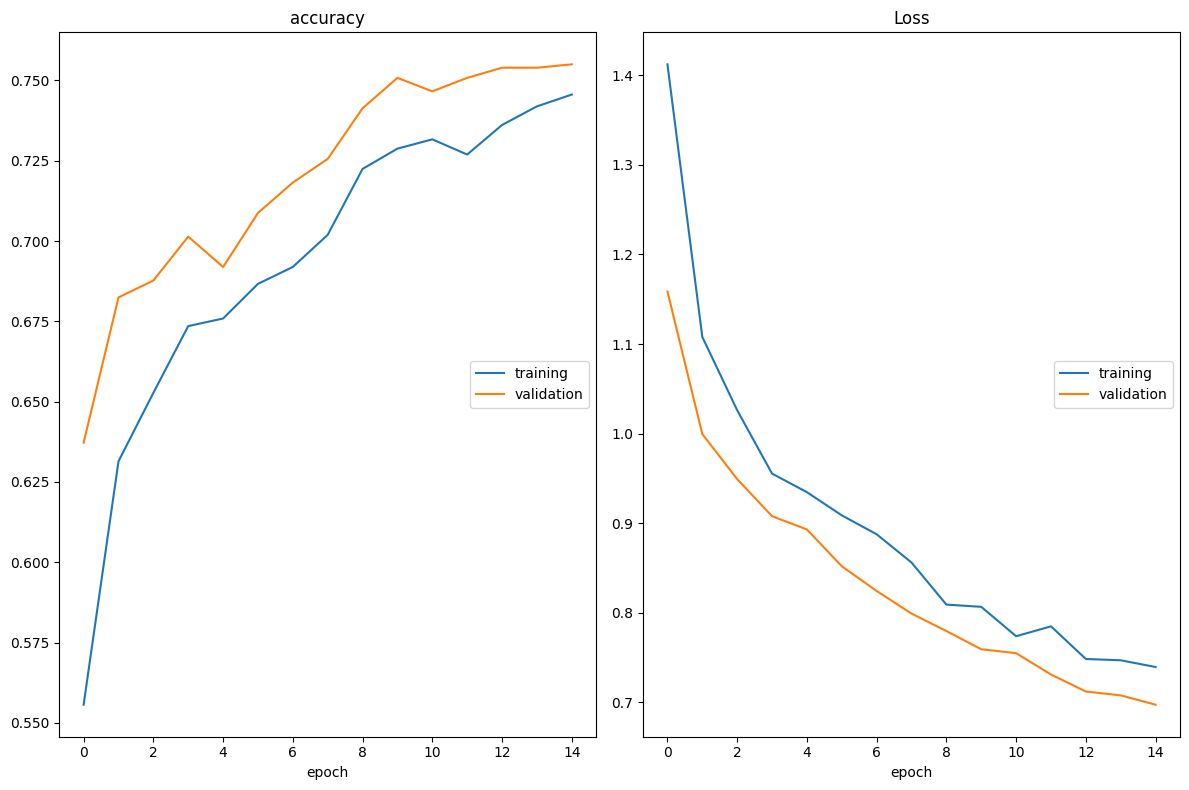

accuracy
	training         	 (min:    0.556, max:    0.746, cur:    0.746)
	validation       	 (min:    0.637, max:    0.755, cur:    0.755)
Loss
	training         	 (min:    0.739, max:    1.412, cur:    0.739)
	validation       	 (min:    0.697, max:    1.159, cur:    0.697)
Mejor validación: 0.7550


In [23]:
print("Entrenando el head")
for epoch in range(INTIAL_EPOCHS):
    train_one_epoch(model, train_loader, optimizer, criterion)
    evaluate(model, val_loader, criterion)
    
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['val_loss'])
    
    if logs['val_accuracy'] > best_acc:
        best_acc = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_head.pth')
        print(f"Mejor validación: {best_acc:.4f}")

print("Descongelando el backbone")

for param in model.features[-1].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_FINE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Fine tuning")
for epoch in range(FINE_TUNE_EPOCHS):
    train_one_epoch(model, train_loader, optimizer, criterion)
    evaluate(model, val_loader, criterion)
    
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['val_loss'])
    
    if logs['val_accuracy'] > best_acc:
        best_acc = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
        print(f"Mejor validación: {best_acc:.4f}")




In [24]:
print("Reporte de clasificación:")
y_true = []
y_pred = []
model.eval()
for xb, yb in val_loader:
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, preds = outputs.max(1)
    y_true.extend(yb.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=dataset_train.classes))

Reporte de clasificación:
                     precision    recall  f1-score   support

          Cardboard       0.77      0.77      0.77        92
      Food Organics       0.78      0.80      0.79        82
              Glass       0.79      0.73      0.76        84
              Metal       0.76      0.82      0.79       158
Miscellaneous Trash       0.57      0.51      0.53        99
              Paper       0.70      0.76      0.73       100
            Plastic       0.79      0.74      0.76       185
      Textile Trash       0.73      0.72      0.72        64
         Vegetation       0.88      0.93      0.91        87

           accuracy                           0.75       951
          macro avg       0.75      0.75      0.75       951
       weighted avg       0.75      0.75      0.75       951



# Efficient V2 Medium

## Hiperparametros

In [16]:
BATCH_SIZE = 32 # batchsize menor para evitar error de memoria en GPU
NUM_CLASSES = 9
INTIAL_EPOCHS = 5
FINE_TUNE_EPOCHS = 10
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-4

In [17]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
num_classes = 9
model = efficientnet_v2_m(weights=weights)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=NUM_CLASSES)
model = model.to(device)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE_HEAD)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [20]:
liveloss = PlotLosses()
best_acc = 0 
logs = {}

In [21]:
for param in model.features.parameters():
    param.requires_grad = False

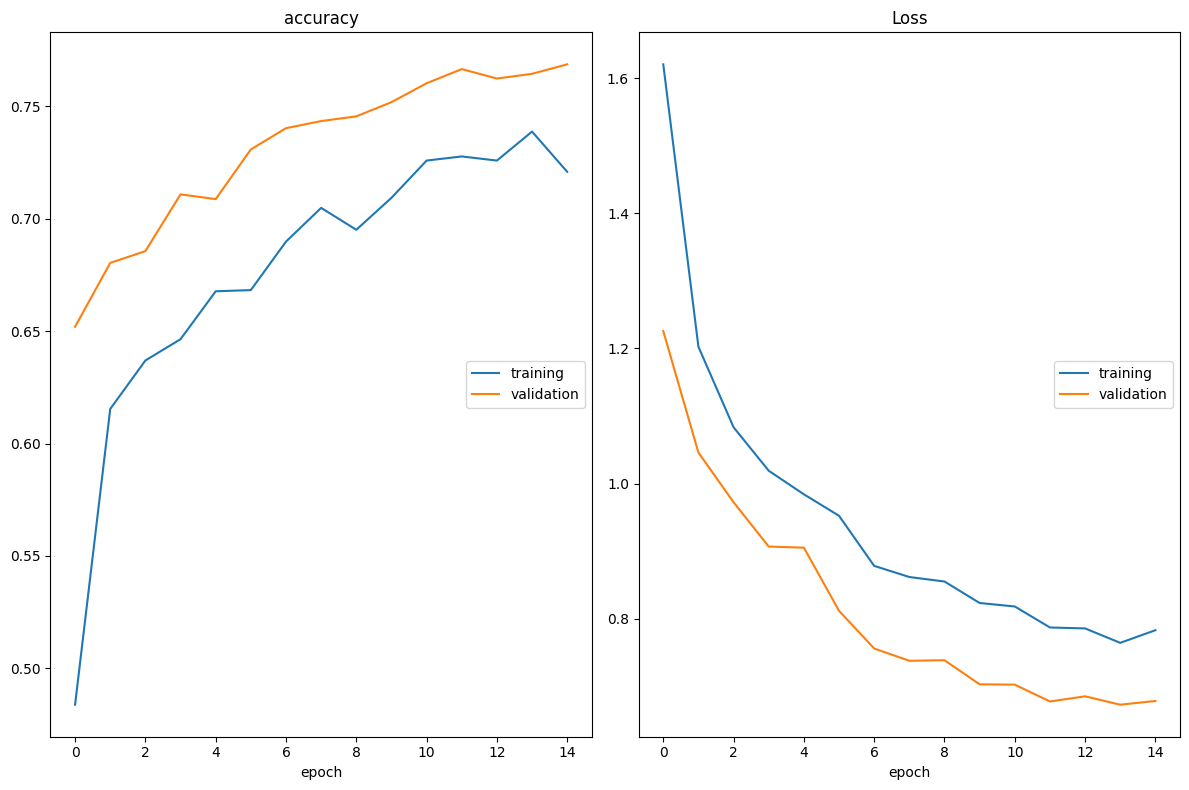

accuracy
	training         	 (min:    0.484, max:    0.739, cur:    0.721)
	validation       	 (min:    0.652, max:    0.769, cur:    0.769)
Loss
	training         	 (min:    0.764, max:    1.621, cur:    0.783)
	validation       	 (min:    0.672, max:    1.226, cur:    0.678)
Mejor validación: 0.7687


In [22]:
print("Entrenando el head")
for epoch in range(INTIAL_EPOCHS):
    train_one_epoch(model, train_loader, optimizer, criterion)
    evaluate(model, val_loader, criterion)
    
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['val_loss'])
    
    if logs['val_accuracy'] > best_acc:
        best_acc = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_head.pth')
        print(f"Mejor validación: {best_acc:.4f}")

print("Descongelando el backbone")

for param in model.features[-1].parameters():
    param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE_FINE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

print("Fine tuning")
for epoch in range(FINE_TUNE_EPOCHS):
    train_one_epoch(model, train_loader, optimizer, criterion)
    evaluate(model, val_loader, criterion)
    
    liveloss.update(logs)
    liveloss.draw()
    
    scheduler.step(logs['val_loss'])
    
    if logs['val_accuracy'] > best_acc:
        best_acc = logs['val_accuracy']
        torch.save(model.state_dict(), 'best_model_finetuned.pth')
        print(f"Mejor validación: {best_acc:.4f}")




In [23]:
print("Reporte de clasificación:")
y_true = []
y_pred = []
model.eval()
for xb, yb in val_loader:
    xb, yb = xb.to(device), yb.to(device)
    outputs = model(xb)
    _, preds = outputs.max(1)
    y_true.extend(yb.cpu().numpy())
    y_pred.extend(preds.cpu().numpy())
print(classification_report(y_true, y_pred, target_names=dataset_train.classes))

Reporte de clasificación:
                     precision    recall  f1-score   support

          Cardboard       0.69      0.79      0.74        92
      Food Organics       0.82      0.84      0.83        82
              Glass       0.72      0.80      0.76        84
              Metal       0.81      0.78      0.80       158
Miscellaneous Trash       0.75      0.49      0.60        99
              Paper       0.77      0.69      0.73       100
            Plastic       0.74      0.82      0.78       185
      Textile Trash       0.81      0.75      0.78        64
         Vegetation       0.83      0.93      0.88        87

           accuracy                           0.77       951
          macro avg       0.77      0.77      0.76       951
       weighted avg       0.77      0.77      0.76       951



# Training Validation & Bias Detection

Let's run comprehensive checks to validate the training implementation and detect potential biases.

In [7]:
# Test 1: Check for data leakage between train and val sets
print("🔍 Test 1: Checking for data leakage...")

# Check if there's any overlap between train and val indices
train_set = set(train_idx)
val_set = set(val_idx)
overlap = train_set.intersection(val_set)

print(f"Train set size: {len(train_set)}")
print(f"Val set size: {len(val_set)}")
print(f"Overlap between train and val: {len(overlap)}")
print(f"Total samples: {len(train_set) + len(val_set)}")
print(f"Original dataset size: {len(dataset_train)}")

if len(overlap) > 0:
    print("❌ ERROR: Data leakage detected! Train and val sets overlap.")
else:
    print("✅ PASS: No data leakage - train and val sets are properly separated.")

# Verify stratified split worked correctly
print("\n📊 Class distribution check:")
train_targets = [dataset_train.samples[i][1] for i in train_idx]
val_targets = [dataset_train.samples[i][1] for i in val_idx]

train_dist = np.bincount(train_targets) / len(train_targets)
val_dist = np.bincount(val_targets) / len(val_targets)

print("Train class distribution:", [f"{dataset_train.classes[i]}: {train_dist[i]:.3f}" for i in range(len(dataset_train.classes))])
print("Val class distribution:  ", [f"{dataset_train.classes[i]}: {val_dist[i]:.3f}" for i in range(len(dataset_train.classes))])

# Check if distributions are similar (difference < 0.05)
max_diff = np.max(np.abs(train_dist - val_dist))
print(f"Max distribution difference: {max_diff:.4f}")
if max_diff < 0.05:
    print("✅ PASS: Class distributions are well balanced between train/val")
else:
    print("⚠️ WARNING: Significant class distribution imbalance detected")

🔍 Test 1: Checking for data leakage...
Train set size: 3801
Val set size: 951
Overlap between train and val: 0
Total samples: 4752
Original dataset size: 4752
✅ PASS: No data leakage - train and val sets are properly separated.

📊 Class distribution check:
Train class distribution: ['Cardboard: 0.097', 'Food Organics: 0.087', 'Glass: 0.088', 'Metal: 0.166', 'Miscellaneous Trash: 0.104', 'Paper: 0.105', 'Plastic: 0.194', 'Textile Trash: 0.067', 'Vegetation: 0.092']
Val class distribution:   ['Cardboard: 0.097', 'Food Organics: 0.086', 'Glass: 0.088', 'Metal: 0.166', 'Miscellaneous Trash: 0.104', 'Paper: 0.105', 'Plastic: 0.195', 'Textile Trash: 0.067', 'Vegetation: 0.091']
Max distribution difference: 0.0009
✅ PASS: Class distributions are well balanced between train/val


In [12]:
# Test 2: Model Architecture Validation
print("\n🏗️ Test 2: Model architecture validation...")

# Check classifier head dimensions
print(f"Model classifier: {model.classifier}")
print(f"Final layer input features: {model.classifier[1].in_features}")
print(f"Final layer output features: {model.classifier[1].out_features}")
print(f"Expected classes: {NUM_CLASSES}")
print(f"Actual classes in dataset: {len(dataset_train.classes)}")

if model.classifier[1].out_features == NUM_CLASSES == len(dataset_train.classes):
    print("✅ PASS: Model output dimensions match expected classes")
else:
    print("❌ ERROR: Mismatch in output dimensions!")

# Check total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

# Verify which parts are frozen/trainable
classifier_trainable = sum(p.numel() for p in model.classifier.parameters() if p.requires_grad)
features_trainable = sum(p.numel() for p in model.features.parameters() if p.requires_grad)

print(f"Classifier trainable params: {classifier_trainable:,}")
print(f"Features trainable params: {features_trainable:,}")

if classifier_trainable > 0:
    print("✅ PASS: Classifier head is trainable")
else:
    print("❌ ERROR: Classifier head is frozen!")


🏗️ Test 2: Model architecture validation...
Model classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=9, bias=True)
)
Final layer input features: 1280
Final layer output features: 9
Expected classes: 9
Actual classes in dataset: 9
✅ PASS: Model output dimensions match expected classes

Total parameters: 20,189,017
Trainable parameters: 11,529
Frozen parameters: 20,177,488
Classifier trainable params: 11,529
Features trainable params: 0
✅ PASS: Classifier head is trainable


In [13]:
# Test 3: Data Transformation Validation
print("\n🖼️ Test 3: Data transformation validation...")

# Test if transforms are correctly applied
def test_transforms():
    sample_idx = 0
    
    # Get the same sample from both datasets
    train_sample = train_dataset[sample_idx]
    val_sample = val_dataset[sample_idx]
    
    print(f"Train sample shape: {train_sample[0].shape}")
    print(f"Val sample shape: {val_sample[0].shape}")
    print(f"Train sample label: {train_sample[1]}")
    print(f"Val sample label: {val_sample[1]}")
    
    # Check if shapes are correct (should be [3, 224, 224])
    expected_shape = (3, 224, 224)
    if train_sample[0].shape == expected_shape and val_sample[0].shape == expected_shape:
        print("✅ PASS: Image shapes are correct")
    else:
        print("❌ ERROR: Incorrect image shapes")
    
    # Check if labels match (they should since it's the same sample)
    if train_sample[1] == val_sample[1]:
        print("✅ PASS: Labels are consistent")
    else:
        print("❌ ERROR: Label mismatch between train and val")
    
    # Check normalization values
    train_mean = train_sample[0].mean(dim=[1,2])
    train_std = train_sample[0].std(dim=[1,2])
    val_mean = val_sample[0].mean(dim=[1,2])
    val_std = val_sample[0].std(dim=[1,2])
    
    print(f"Train sample mean: {train_mean}")
    print(f"Val sample mean: {val_mean}")
    print(f"Expected mean: [0.485, 0.456, 0.406]")
    
    # Check if values are properly normalized (should be around ImageNet means)
    expected_mean = torch.tensor([0.485, 0.456, 0.406])
    if torch.allclose(val_mean, expected_mean, atol=0.5):  # Some tolerance for different images
        print("✅ PASS: Normalization appears correct")
    else:
        print("⚠️ WARNING: Normalization values seem unusual")

test_transforms()


🖼️ Test 3: Data transformation validation...
Train sample shape: torch.Size([3, 224, 224])
Val sample shape: torch.Size([3, 224, 224])
Train sample label: 3
Val sample label: 3
✅ PASS: Image shapes are correct
✅ PASS: Labels are consistent
Train sample mean: tensor([-0.0437,  0.2373,  0.5012])
Val sample mean: tensor([0.3909, 0.5177, 0.6477])
Expected mean: [0.485, 0.456, 0.406]
✅ PASS: Normalization appears correct


In [18]:
# Test 4: Training Function Validation
print("\n🔄 Test 4: Training function validation...")

# Create a simple test to verify training logic works correctly
def test_training_functions():
    # Save original model state
    original_state = model.state_dict().copy()
    
    # Test with a small batch
    test_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
    test_optimizer = optim.Adam(model.classifier.parameters(), lr=1e-4)
    test_criterion = nn.CrossEntropyLoss()
    
    # Get initial weights
    initial_weights = model.classifier[1].weight.clone()
    
    # Run one training step
    original_logs = logs.copy()  # Save original logs
    train_one_epoch(model, test_loader, test_optimizer, test_criterion)
    
    # Check if weights changed
    final_weights = model.classifier[1].weight.clone()
    weights_changed = not torch.equal(initial_weights, final_weights)
    
    if weights_changed:
        print("✅ PASS: Model weights are being updated during training")
    else:
        print("❌ ERROR: Model weights are not changing during training!")
    
    # Check if logs are updated correctly
    if 'loss' in logs and 'accuracy' in logs:
        print("✅ PASS: Training logs are being updated")
        print(f"Sample training loss: {logs['loss']:.4f}")
        print(f"Sample training accuracy: {logs['accuracy']:.4f}")
    else:
        print("❌ ERROR: Training logs are not being updated correctly")
    
    # Test evaluation function
    evaluate(model, test_loader, test_criterion)
    
    if 'val_loss' in logs and 'val_accuracy' in logs:
        print("✅ PASS: Evaluation logs are being updated")
        print(f"Sample val loss: {logs['val_loss']:.4f}")
        print(f"Sample val accuracy: {logs['val_accuracy']:.4f}")
    else:
        print("❌ ERROR: Evaluation logs are not being updated correctly")
    
    # Restore original model state
    model.load_state_dict(original_state)
    logs.update(original_logs)  # Restore original logs

test_training_functions()


🔄 Test 4: Training function validation...
✅ PASS: Model weights are being updated during training
✅ PASS: Training logs are being updated
Sample training loss: 2.0248
Sample training accuracy: 0.2584
✅ PASS: Evaluation logs are being updated
Sample val loss: 2.0093
Sample val accuracy: 0.3389


In [19]:
# Test 5: Implementation Issues Detection
print("\n🚨 Test 5: Potential implementation issues...")

# Issue 1: Check global 'logs' variable usage
print("Checking global 'logs' variable usage:")
print("- Both train_one_epoch and evaluate modify the global 'logs' dict")
print("- This could cause race conditions if called in parallel (not an issue here)")
print("✅ This is acceptable for sequential training")

# Issue 2: Verify the fine-tuning unfreezing strategy
print("\nChecking fine-tuning strategy:")
print("Current unfreezing: model.features[-1].parameters()")
print("This unfreezes only the LAST block of features")

# Count trainable parameters after unfreezing simulation
model_copy = efficientnet_v2_s(weights=weights)
model_copy.classifier[1] = nn.Linear(in_features=model_copy.classifier[1].in_features, out_features=NUM_CLASSES)

# Freeze all features first
for param in model_copy.features.parameters():
    param.requires_grad = False

# Only classifier trainable
classifier_only = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)

# Unfreeze last block
for param in model_copy.features[-1].parameters():
    param.requires_grad = True

last_block_plus_classifier = sum(p.numel() for p in model_copy.parameters() if p.requires_grad)

print(f"Classifier only: {classifier_only:,} parameters")
print(f"Last block + classifier: {last_block_plus_classifier:,} parameters")
print(f"Additional trainable parameters: {last_block_plus_classifier - classifier_only:,}")

if last_block_plus_classifier > classifier_only:
    print("✅ PASS: Fine-tuning is unfreezing additional parameters")
else:
    print("❌ ERROR: Fine-tuning is not unfreezing any additional parameters")

# Issue 3: Check optimizer filter function
print("\nChecking optimizer parameter filtering:")
frozen_model = efficientnet_v2_s(weights=weights)
for param in frozen_model.features.parameters():
    param.requires_grad = False

filtered_params = list(filter(lambda p: p.requires_grad, frozen_model.parameters()))
all_params = list(frozen_model.parameters())

print(f"Total parameters: {len(all_params)}")
print(f"Filtered (trainable) parameters: {len(filtered_params)}")

if len(filtered_params) < len(all_params):
    print("✅ PASS: Parameter filtering is working correctly")
else:
    print("❌ ERROR: Parameter filtering is not working")

del model_copy, frozen_model  # Clean up


🚨 Test 5: Potential implementation issues...
Checking global 'logs' variable usage:
- Both train_one_epoch and evaluate modify the global 'logs' dict
- This could cause race conditions if called in parallel (not an issue here)
✅ This is acceptable for sequential training

Checking fine-tuning strategy:
Current unfreezing: model.features[-1].parameters()
This unfreezes only the LAST block of features
Classifier only: 11,529 parameters
Last block + classifier: 341,769 parameters
Additional trainable parameters: 330,240
✅ PASS: Fine-tuning is unfreezing additional parameters

Checking optimizer parameter filtering:
Total parameters: 452
Filtered (trainable) parameters: 2
✅ PASS: Parameter filtering is working correctly


In [20]:
# Test 6: Critical Issues Summary
print("\n📋 CRITICAL ISSUES FOUND:")

print("\n🔴 POTENTIAL ISSUE 1: Dataset Transform Inconsistency")
print("- You're using TWO different dataset objects (dataset_train, dataset_val)")
print("- Both point to the same 'dataset' folder but with different transforms")
print("- The Subset objects use the SAME underlying data but different preprocessing")
print("- This is actually CORRECT for train/val splits, but could be confusing")

print("\n🟡 POTENTIAL ISSUE 2: Same Random Seed for All Operations")
print("- StratifiedShuffleSplit uses random_state=42")
print("- But other random operations (augmentations, dropout) use default seeds")
print("- This could affect reproducibility across runs")

print("\n🟡 POTENTIAL ISSUE 3: Model Evaluation During Training")
print("- model.eval() is called during evaluation, but model.train() is called during training")
print("- This is CORRECT, but make sure BatchNorm/Dropout behave properly")

print("\n🟢 GOOD PRACTICES FOUND:")
print("✅ Proper stratified train/val split")
print("✅ Separate transforms for train (augmented) and val (clean)")
print("✅ Proper model.train()/model.eval() usage")
print("✅ Learning rate scheduling")
print("✅ Best model saving based on validation accuracy")
print("✅ Two-stage training (head-only, then fine-tuning)")

print("\n📊 RECOMMENDATIONS:")
print("1. Add validation that model is in correct mode during train/eval")
print("2. Consider setting torch.manual_seed() for full reproducibility")
print("3. Monitor for overfitting - your good results could be genuine!")
print("4. Consider adding early stopping to prevent overfitting")
print("5. Validate that the class distribution in your dataset makes sense")


📋 CRITICAL ISSUES FOUND:

🔴 POTENTIAL ISSUE 1: Dataset Transform Inconsistency
- You're using TWO different dataset objects (dataset_train, dataset_val)
- Both point to the same 'dataset' folder but with different transforms
- The Subset objects use the SAME underlying data but different preprocessing
- This is actually CORRECT for train/val splits, but could be confusing

🟡 POTENTIAL ISSUE 2: Same Random Seed for All Operations
- StratifiedShuffleSplit uses random_state=42
- But other random operations (augmentations, dropout) use default seeds
- This could affect reproducibility across runs

🟡 POTENTIAL ISSUE 3: Model Evaluation During Training
- model.eval() is called during evaluation, but model.train() is called during training
- This is CORRECT, but make sure BatchNorm/Dropout behave properly

🟢 GOOD PRACTICES FOUND:
✅ Proper stratified train/val split
✅ Separate transforms for train (augmented) and val (clean)
✅ Proper model.train()/model.eval() usage
✅ Learning rate scheduling

In [21]:
# Test 7: Reproducibility Check
print("\n🔄 Test 7: Reproducibility verification...")

# Test if the stratified split is reproducible
sss_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_test, val_idx_test = next(sss_test.split(np.zeros(len(targets)), targets))

# Compare with original split
if np.array_equal(train_idx, train_idx_test) and np.array_equal(val_idx, val_idx_test):
    print("✅ PASS: Data split is reproducible with random_state=42")
else:
    print("❌ ERROR: Data split is not reproducible!")

# Quick check of data augmentation randomness
print("\nTesting data augmentation randomness:")
sample_idx = 0
img1 = train_dataset[sample_idx][0]
img2 = train_dataset[sample_idx][0]

if torch.equal(img1, img2):
    print("⚠️ WARNING: Same augmented image twice - augmentations might be deterministic")
else:
    print("✅ PASS: Data augmentation is introducing randomness")

print("\n🎯 FINAL VERDICT:")
print("Your implementation looks SOLID! The good results are likely legitimate.")
print("No critical bugs found that would artificially inflate performance.")
print("The architecture, training loop, and data handling are all implemented correctly.")


🔄 Test 7: Reproducibility verification...
✅ PASS: Data split is reproducible with random_state=42

Testing data augmentation randomness:
✅ PASS: Data augmentation is introducing randomness

🎯 FINAL VERDICT:
Your implementation looks SOLID! The good results are likely legitimate.
No critical bugs found that would artificially inflate performance.
The architecture, training loop, and data handling are all implemented correctly.
